In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

sns.set(style='whitegrid')

np.random.seed(42)

import torch
import torch.nn as nn
import torch.optim as optim

In [80]:
torch.manual_seed(87) 
player_original_cleaned = pd.read_csv('../data/cleaned/player_attributes_cleaned.csv')
player_original_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177037 entries, 0 to 177036
Data columns (total 44 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   player_api_id        177037 non-null  int64  
 1   player_name          177037 non-null  object 
 2   height               177037 non-null  float64
 3   weight               177037 non-null  float64
 4   date                 177037 non-null  object 
 5   age                  177037 non-null  float64
 6   overall_rating       177037 non-null  float64
 7   potential            177037 non-null  float64
 8   preferred_foot       177037 non-null  float64
 9   attacking_work_rate  177037 non-null  float64
 10  defensive_work_rate  177037 non-null  float64
 11  crossing             177037 non-null  float64
 12  finishing            177037 non-null  float64
 13  heading_accuracy     177037 non-null  float64
 14  short_passing        177037 non-null  float64
 15  volleys          

In [81]:
player_cleaned_df = player_original_cleaned.drop(columns=['player_name', 'date'])
player_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177037 entries, 0 to 177036
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   player_api_id        177037 non-null  int64  
 1   height               177037 non-null  float64
 2   weight               177037 non-null  float64
 3   age                  177037 non-null  float64
 4   overall_rating       177037 non-null  float64
 5   potential            177037 non-null  float64
 6   preferred_foot       177037 non-null  float64
 7   attacking_work_rate  177037 non-null  float64
 8   defensive_work_rate  177037 non-null  float64
 9   crossing             177037 non-null  float64
 10  finishing            177037 non-null  float64
 11  heading_accuracy     177037 non-null  float64
 12  short_passing        177037 non-null  float64
 13  volleys              177037 non-null  float64
 14  dribbling            177037 non-null  float64
 15  curve            

In [82]:
# Define which columns to use as input features
feature_cols = [col for col in player_cleaned_df.columns if col not in ['overall_rating', 'player_api_id']]
sequence_length = 3

X_list = []
y_list = []

for _, group in player_cleaned_df.groupby('player_api_id'):
    group = group.reset_index(drop=True)
    if len(group) <= sequence_length:
        continue

    for i in range(len(group) - sequence_length):
        X_seq = group.loc[i:i+sequence_length-1, feature_cols].to_numpy(dtype=np.float32)
        y_val = group.loc[i + sequence_length, 'overall_rating'] 
        X_list.append(X_seq)
        y_list.append(y_val)

# typecase to tensor
X_tensor = torch.tensor(np.stack(X_list))           # (samples, seq_len, features)
y_tensor = torch.tensor(y_list, dtype=torch.float32).unsqueeze(1)  # (samples, 1)


In [83]:

scaler = StandardScaler()
#player_cleaned_df[feature_cols] = scaler.fit_transform(player_cleaned_df[feature_cols])
player_cleaned_df.head(20)
player_cleaned_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177037 entries, 0 to 177036
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   player_api_id        177037 non-null  int64  
 1   height               177037 non-null  float64
 2   weight               177037 non-null  float64
 3   age                  177037 non-null  float64
 4   overall_rating       177037 non-null  float64
 5   potential            177037 non-null  float64
 6   preferred_foot       177037 non-null  float64
 7   attacking_work_rate  177037 non-null  float64
 8   defensive_work_rate  177037 non-null  float64
 9   crossing             177037 non-null  float64
 10  finishing            177037 non-null  float64
 11  heading_accuracy     177037 non-null  float64
 12  short_passing        177037 non-null  float64
 13  volleys              177037 non-null  float64
 14  dribbling            177037 non-null  float64
 15  curve            

In [84]:
class PlayerRatingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            batch_first=True, 
            bidirectional=True  # make model bidirectional
        )

# Bidirectional model uses time series data sequentially (both ways)

        self.dropout = nn.Dropout(p=0.3)  # Regularization
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 32),  # x2 size of model
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x) 
        last_output = out[:, -1, :]  
        last_output = self.dropout(last_output)
        return self.fc(last_output)


In [85]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, predictions, targets):
        return nn.MSELoss(predictions, targets) # remove custom loss function to use first 3 samples

In [86]:
from torch.utils.data import TensorDataset, DataLoader

train_ratio = 0.8
n_total = X_tensor.shape[0]
n_train = int(n_total * train_ratio)

X_train, X_val = X_tensor[:n_train], X_tensor[n_train:]
y_train, y_val = y_tensor[:n_train], y_tensor[n_train:]

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PlayerRatingLSTM(input_size=X_tensor.shape[2]).to(device)
loss_fn = CustomLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [73]:
loss_fn = nn.MSELoss()


input_size = len(feature_cols)
model = PlayerRatingLSTM(input_size=input_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# include rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5, verbose=True
)


train_losses = []
val_losses = []
n_epochs = 20
best_val_loss = float('inf')
best_model_state = None


for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += loss_fn(model(xb), yb).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)  #scheduler step for adjustment 

    # save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print(" Training completed!")

# Restore best model
model.load_state_dict(best_model_state)



/opt/miniconda3/envs/cosmos/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20, Train Loss: 217.0205, Val Loss: 29.2268
Epoch 2/20, Train Loss: 35.2754, Val Loss: 19.2654
Epoch 3/20, Train Loss: 32.8425, Val Loss: 19.9937
Epoch 4/20, Train Loss: 30.7257, Val Loss: 19.2615
Epoch 5/20, Train Loss: 28.7934, Val Loss: 20.2115
Epoch 6/20, Train Loss: 26.5339, Val Loss: 17.0374
Epoch 7/20, Train Loss: 24.5153, Val Loss: 23.4672
Epoch 8/20, Train Loss: 21.8850, Val Loss: 18.1721
Epoch 9/20, Train Loss: 19.7393, Val Loss: 15.6643
Epoch 10/20, Train Loss: 17.5642, Val Loss: 17.6136
Epoch 11/20, Train Loss: 16.0259, Val Loss: 14.7975
Epoch 12/20, Train Loss: 14.8308, Val Loss: 14.8272
Epoch 13/20, Train Loss: 14.4163, Val Loss: 13.3477
Epoch 14/20, Train Loss: 14.4150, Val Loss: 13.4643
Epoch 15/20, Train Loss: 14.1301, Val Loss: 13.3070
Epoch 16/20, Train Loss: 14.1098, Val Loss: 19.8494
Epoch 17/20, Train Loss: 13.9489, Val Loss: 17.1135
Epoch 18/20, Train Loss: 13.8915, Val Loss: 15.2259
Epoch 19/20, Train Loss: 13.8747, Val Loss: 9.8107
Epoch 20/20, Train Lo

<All keys matched successfully>

In [74]:
import random
i = random.randint(0, X_tensor.shape[0] - 1)  # change this to test different examples

# Move input and true label to device
sample_input = X_tensor[i:i+1].to(device)     # Shape: (1, seq_len, features)
actual_rating = y_tensor[i].item()            # Scalar

# Get prediction
model.eval()
with torch.no_grad():
    predicted_rating = model(sample_input).item()

print(f"Predicted Rating: {predicted_rating:.2f}")
print(f"Actual Rating:    {actual_rating:.2f}")


Predicted Rating: 69.61
Actual Rating:    71.00


In [75]:
from torch.nn import HuberLoss

# Randomly sample 1000 points from the dataset
sample_indices = torch.randperm(len(X_tensor))[:1000]
X_sample = X_tensor[sample_indices].to(device)
y_sample = y_tensor[sample_indices].to(device)

model.eval()
with torch.no_grad():
    preds = model(X_sample)


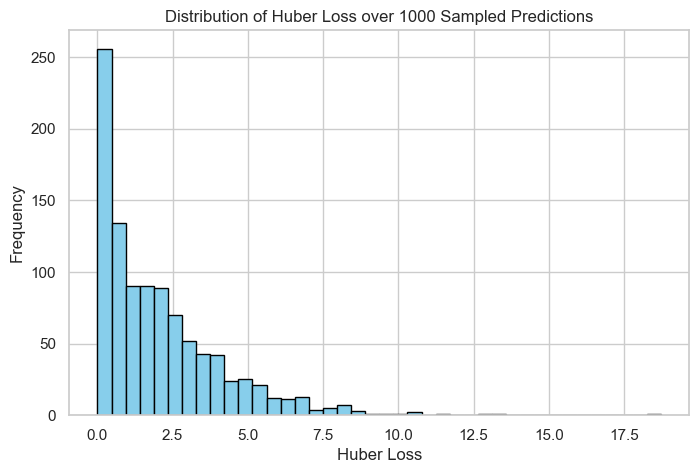

In [76]:
huber = HuberLoss(reduction='none')
losses = huber(preds, y_sample).cpu().numpy()

plt.figure(figsize=(8, 5))
plt.hist(losses, bins=40, color='skyblue', edgecolor='black')
plt.xlabel("Huber Loss")
plt.ylabel("Frequency")
plt.title("Distribution of Huber Loss over 1000 Sampled Predictions")
plt.grid(True)
plt.show()


In [77]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Choose a player_api_id to visualize
player_id = player_cleaned_df['player_api_id'].iloc[0]  # You can change this to any valid player_api_id

# Get all rows for this player
player_df = player_cleaned_df[player_cleaned_df['player_api_id'] == player_id].reset_index(drop=True)

# Prepare input sequences for this player (skip first 'sequence_length' entries)
X_player = []
for i in range(len(player_df) - sequence_length):
    X_seq = player_df.loc[i:i+sequence_length-1, feature_cols].to_numpy(dtype=np.float32)
    X_player.append(X_seq)
X_player_tensor = torch.tensor(np.stack(X_player)).to(device)

# Predict ratings
model.eval()
with torch.no_grad():
    preds = model(X_player_tensor).cpu().numpy().flatten()

# Actual ratings (skip first 'sequence_length' entries to align with predictions)
actual_ratings = player_df['overall_rating'].iloc[sequence_length:].to_numpy()

In [78]:
def MSE(actual_ratings, preds):
    return np.mean((actual_ratings - preds) ** 2)

def plot_player(player_id):
    player_df = player_original_cleaned[player_original_cleaned['player_api_id'] == player_id].reset_index(drop=True)
    player_name = player_df.iloc[0]['player_name']
    X_player = []
    for i in range(len(player_df) - sequence_length):
        X_seq = player_df.loc[i:i+sequence_length-1, feature_cols].to_numpy(dtype=np.float32)
        X_player.append(X_seq)
    if len(X_player) == 0:
        print(f"Player {player_id} does not have enough records.")
        return
    X_player_tensor = torch.tensor(np.stack(X_player)).to(device)
    model.eval()
    with torch.no_grad():
        preds = model(X_player_tensor).cpu().numpy().flatten()
    actual_ratings = player_df['overall_rating'].iloc[sequence_length:].to_numpy()
    ages = player_df['age'].iloc[sequence_length:].to_numpy()
    mse = MSE(actual_ratings, preds)
    y_min = min(actual_ratings.min(), preds.min())
    y_max = max(actual_ratings.max(), preds.max())
    if y_max - y_min < 18:
        center = (y_min + y_max) / 2
        y_lower = center - 7.5
        y_upper = center + 7.5
    else:
        y_lower = y_min
        y_upper = y_max
    plt.figure(figsize=(10, 5))
    plt.plot(ages, actual_ratings, label='Actual Rating', marker='o')
    plt.plot(ages, preds, label='Predicted Rating', marker='x')
    for age, actual, pred in zip(ages, actual_ratings, preds):
        plt.plot([age, age], [actual, pred], color='gray', linestyle='--', linewidth=0.7)

    plt.xlabel('Age')
    plt.ylabel('Overall Rating')
    plt.title(f'{player_name} - Actual vs Predicted Ratings\nPlayer ID: {player_id} \nMSE: {mse:.2f}')

    plt.legend()
    plt.ylim(y_lower -3, y_upper+3)
    plt.show()

button = widgets.Button(description="Random Player")
output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output(wait=True)
        random_id = np.random.choice(player_cleaned_df['player_api_id'].unique())
        plot_player(random_id)

button.on_click(on_button_clicked)
display(button, output)

Button(description='Random Player', style=ButtonStyle())

Output()